### This notebook demonstrates how a popularity score is generated for fictions.

In [16]:
import numpy as np
import dill
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression

df_fics = dill.load(open('fics_info.pkd', 'rb'))

AO3 allows users to leave kudos, which is essentially a thumb-up for fictions; it can only be given once for each user and it cannot be retracted. The number of kudos a fiction receives is of course time-dependent, in the sense that a work published earlier is like to be seen by more people, thus receiving more kudos. Kudos divided by hits seems to be a better metric. Below plot shows how work created in 2015 tend to receive more kudos than work created in 2018; but the kudos/hits ratio shows no obvious dependence in time.

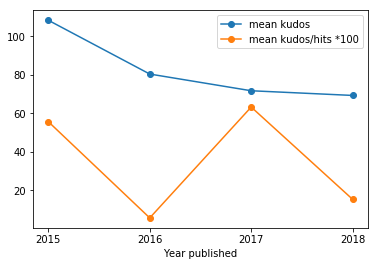

In [29]:
date = np.asarray(list(dict(df_fics['date']).values()))
kudos = np.asarray(list(dict(df_fics['kudoscnt']).values()))
hits = np.asarray(list(dict(df_fics['hits']).values()))
kudos_ratio = kudos/(hits+1) #Avoid division by zero

mean_kudos = np.zeros(4)
mean_ratio = np.zeros(4)

for y in range(2015,2019):
    mean_kudos[y-2015] = np.mean(kudos[np.logical_and(date > datetime.strptime(str(y),'%Y'),
                                                date < datetime.strptime(str(y+1),'%Y'))])
    mean_ratio[y-2015] = np.mean(kudos_ratio[np.logical_and(date > datetime.strptime(str(y),'%Y'),
                                                date < datetime.strptime(str(y+1),'%Y'))])

fig, ax = plt.subplots()
ax.plot(np.arange(2015,2019),mean_kudos,'-o',label='mean kudos')
ax.plot(np.arange(2015,2019),mean_ratio*100,'-o',label='mean kudos/hits *100')
ax.set_xticks(np.arange(2015,2019))
ax.set_xlabel('Year published')
ax.legend()

But I also need to consider what happens with multi-chapter works - People tend to come back and check if there're updates when there's an interesting on-going work, but one user is only allowed to give one kudos. So a multichapter work on-going for a long time is likely to get a lot of hits but just as many kudos as a one-shot. Not fair, hah? People have been bitching about this feature for a while now but it seems AO3 is not gonna change that any time soon. So I'm gonna factor that in. Look at the plots below, I'd say it looks more or less exponential.

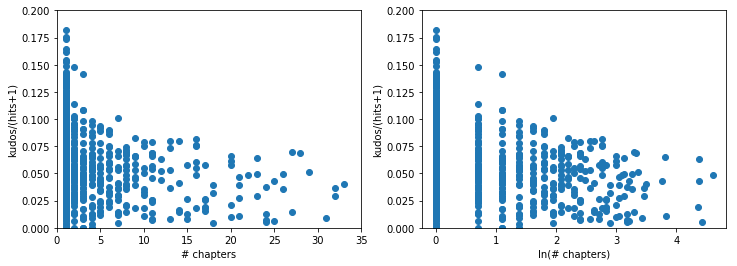

In [53]:
nchp = [int(row['chaptercnt'].partition('/')[0]) for index, row in df_fics.iterrows()]
nchp = np.asarray(nchp)

fig, ax = plt.subplots(1,2,figsize=(12, 4))
ax[0].plot(nchp,kudos_ratio,'o')
ax[1].plot(np.log(nchp),kudos_ratio,'o')
ax[0].set_ylim((0,.2))
ax[0].set_xlim((0,35))
ax[1].set_ylim((0,.2))
ax[0].set_xlabel('# chapters')
ax[1].set_xlabel('ln(# chapters)')
for x in ax:
    x.set_ylabel('kudos/(hits+1)')

Obviously this data set is not good for linear regression, since the std is not constant in the sample set. What I'm gonna do is to fit both the mean and std to the chapter count, and calculate the popularity score for individual fictions accordingly:
popularity_score = (kudos/hits - sample_mean)/sample_std

In [61]:
X = np.log(nchp).reshape(-1,1)
y = kudos_ratio
#mean
nmax = 15
mean = np.zeros(nmax)
for i in range(nmax):
    seg = y[nchp ==i+1]
    seg = seg[seg <0.2]#Remove outliers
    mean[i] = np.mean(seg)
    
lg1 = LinearRegression()
reg = lg1.fit(np.log(np.arange(nmax)+1).reshape(-1,1),mean)
print(reg.coef_,reg.intercept_)



[-0.00688043] 0.0600842862138896


In [62]:
#std
nmax = 15
std = np.zeros(nmax)
for i in range(nmax):
    seg = y[nchp ==i+1]
    seg = seg[seg <0.2]#Remove outliers
    std[i] = np.std(seg)

lg2 = LinearRegression()
reg_std = lg2.fit(np.log(np.arange(nmax)+1).reshape(-1,1),std)
print(reg_std.coef_,reg.intercept_)

[-0.00479872] 0.0600842862138896


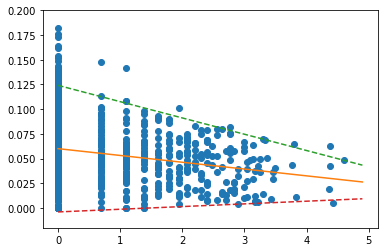

In [71]:
fig, ax = plt.subplots()
ax.plot(np.log(nchp),kudos_ratio,'o')
ax.set_ylim((-.02,.2))
x_grid = np.arange(0,50)/10.
ax.plot(x_grid,lg1.predict(x_grid.reshape(-1,1)),'-')
ax.plot(x_grid,2*lg2.predict(x_grid.reshape(-1,1))+lg1.predict(x_grid.reshape(-1,1)),'--')
ax.plot(x_grid,-2*lg2.predict(x_grid.reshape(-1,1))+lg1.predict(x_grid.reshape(-1,1)),'--')